<a href="https://colab.research.google.com/github/sundarp17/sundar_info5731_fall2020/blob/master/handling_imbalance_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

df =pd.read_csv('/content/stage-1-4.csv')
df.head()

,Sentence,Target
0,at 994.,Invalid
1,Footnote:,Invalid
2,People v. Francisco S. Palacios and Valerie M....,Invalid
3,79-0043A and 79-0044A).,Invalid
4,"Miller v. California, 93 S. Ct. 2607, 2616 n.",Invalid


In [7]:
df['Target'].unique()

array(['Invalid', 'Facts', 'Issue', 'Rule/Law/Holding', 'Conclusion',
       'Analysis', 'Others', 'Rule/Law/holding'], dtype=object)

In [8]:
df['Target']=df['Target'].replace(['Rule/Law/holding'],'Rule/Law/Holding')
df['Target'].unique()

array(['Invalid', 'Facts', 'Issue', 'Rule/Law/Holding', 'Conclusion',
       'Analysis', 'Others'], dtype=object)

Class=3, n=342 (9.301%)
Class=2, n=1829 (49.742%)
Class=4, n=263 (7.153%)
Class=6, n=261 (7.098%)
Class=1, n=324 (8.812%)
Class=0, n=525 (14.278%)
Class=5, n=133 (3.617%)


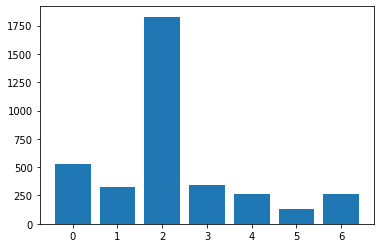

In [9]:
from imblearn.over_sampling import SMOTE
from collections import Counter
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder
data = df.values


# split into input and output elements
X, y = data[:, :-1], data[:, -1]
# label encode the target variable
y = LabelEncoder().fit_transform(y)

# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%s, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

In [12]:
#cleaning
import nltk
import re
import string
nltk.download('stopwords')
nltk.download('wordnet')
stopword=nltk.corpus.stopwords.words('english')
from nltk.stem import WordNetLemmatizer
wl= WordNetLemmatizer()

def clean_text(text):
  text="".join([word.lower() for word in text if word not in string.punctuation])
  tokens = re.split('\W+',text)
  text = [wl.lemmatize(word) for word in tokens if word not in stopword]
  return text



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(analyzer = clean_text)
X_tfidf = tfidf_vect.fit_transform(df['Sentence'])
print(X_tfidf.shape)

(3677, 6371)


In [14]:
#sparse matrix
X_tfidf_df=pd.DataFrame(X_tfidf.toarray())
X_tfidf_df.columns=tfidf_vect.get_feature_names()
X_tfidf_df.head()

,,1,10,100,1000,10000,100000,10000000,10000â,1000x22,1006,1008,1008a,100x22,102,1020,1030,1042,1044,105,10511,1056,1065,107,107c,108,1084,1097,1099,10a,10acre,11,110,1102,111,1116,112,1120,113,1130,...,œsuccessively,œtell,œtestâ,œthat,œthatâ,œthe,œthem,œthere,œthey,œthick,œthis,œthumbusterâ,œto,œtommy,œtoo,œtwo,œunless,œupon,œvery,œvisited,œwaived,œwalked,œwas,œwe,œweaving,œwell,œwhen,œwhere,œwhether,œwhipped,œwhisky,œwhoever,œwhy,œwilliam,œwobblyâ,œwould,œyes,œyou,œyour,œyâ
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Class=Invalid, n=1829 (14.286%)
Class=Facts, n=1829 (14.286%)
Class=Issue, n=1829 (14.286%)
Class=Rule/Law/Holding, n=1829 (14.286%)
Class=Conclusion, n=1829 (14.286%)
Class=Analysis, n=1829 (14.286%)
Class=Others, n=1829 (14.286%)


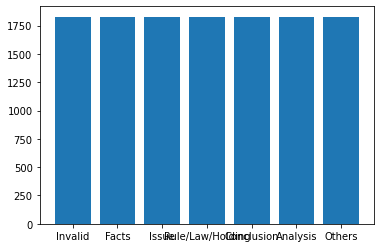

In [19]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE(random_state=777,k_neighbors=5)
X, y = oversample.fit_resample(X_tfidf_df, df['Target'])
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%s, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

In [21]:
#using smote and stochastic gradient boosting
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


X_train, x_test, Y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)
sgd = SGDClassifier(max_iter=1000, tol=1e-3)
sgd.fit(X_train, Y_train)
pred_sgd = sgd.predict(x_test)
print('Accuracy %s' % accuracy_score(pred_sgd,y_test))
print(classification_report(y_test,pred_sgd))

Accuracy 0.8966414996094767
                  precision    recall  f1-score   support

        Analysis       0.87      0.84      0.85       560
      Conclusion       0.88      0.95      0.91       556
           Facts       0.95      0.66      0.77       560
         Invalid       0.87      0.92      0.90       526
           Issue       0.90      0.98      0.94       566
          Others       0.90      0.99      0.94       547
Rule/Law/Holding       0.92      0.96      0.94       526

        accuracy                           0.90      3841
       macro avg       0.90      0.90      0.89      3841
    weighted avg       0.90      0.90      0.89      3841



/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Class=Invalid, n=1829 (14.286%)
Class=Facts, n=1829 (14.286%)
Class=Issue, n=1829 (14.286%)
Class=Rule/Law/Holding, n=1829 (14.286%)
Class=Conclusion, n=1829 (14.286%)
Class=Analysis, n=1829 (14.286%)
Class=Others, n=1829 (14.286%)


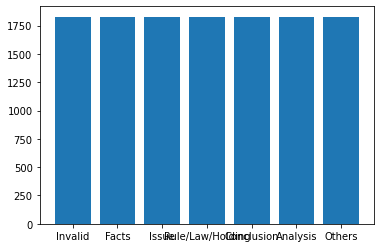

In [25]:
#using RandomOverSampler

from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=777)
X_ROS, y_ROS = ros.fit_sample(X_tfidf_df, df['Target'])
# summarize distribution
counter = Counter(y_ROS)
for k,v in counter.items():
	per = v / len(y_ROS) * 100
	print('Class=%s, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()


In [26]:
X_train, x_test, Y_train, y_test = train_test_split(X_ROS,y_ROS,test_size=0.3,random_state=42)
sgd = SGDClassifier(max_iter=1000, tol=1e-3)
sgd.fit(X_train, Y_train)
pred_sgd = sgd.predict(x_test)
print('Accuracy %s' % accuracy_score(pred_sgd,y_test))
print(classification_report(y_test,pred_sgd))

Accuracy 0.8896120801874512
                  precision    recall  f1-score   support

        Analysis       0.87      0.80      0.84       560
      Conclusion       0.85      0.93      0.89       556
           Facts       0.90      0.70      0.79       560
         Invalid       0.91      0.90      0.90       526
           Issue       0.91      0.95      0.93       566
          Others       0.87      0.99      0.92       547
Rule/Law/Holding       0.92      0.96      0.94       526

        accuracy                           0.89      3841
       macro avg       0.89      0.89      0.89      3841
    weighted avg       0.89      0.89      0.89      3841

